In [1]:
# install required packages
!pip install konlpy

# clear install verbose messages
from IPython.display import clear_output
clear_output()

import urllib.request
import zipfile
from lxml import etree
import re
import tqdm

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')

import gensim
from gensim.models import KeyedVectors, Word2Vec

import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import konlpy
from konlpy.tag import Okt
# from gensim.models.word2vec import Word2Vec


def show_table(df, sample_num=2):
  print('>>> shape :', df.shape)
  print('>>> No of NA :', df.isna().sum().sum())
  if len(df) <= sample_num*2:
    display(df)
  else:
    display(df.head(sample_num))
    display(df.tail(sample_num))
  pass


# nltk : 3.2.5  |  gensim : 3.6.0
print(f'\n>>> nltk : {nltk.__version__}  |  gensim : {gensim.__version__}  |  pd : {pd.__version__}  |  konlpy : {konlpy.__version__}') 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.

>>> nltk : 3.2.5  |  gensim : 3.6.0  |  pd : 1.1.5  |  konlpy : 0.5.2


## 1. 영어 Word2Vec 만들기 (Word2Vec in English)

In [2]:
%%time

# donwload corpus
urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml", filename="ted_en-20160408.xml")

# get text data from corpus
with open('ted_en-20160408.xml') as fp:
  target_text = etree.parse(fp)
text_list = target_text.xpath('//content/text()')

# check text data
print(len(text_list), 'texts \n')
for idx, line in enumerate(text_list[:5]):
  print(f'>>> Line {idx}. {line[:500]}...\n')

2085 texts 

>>> Line 0. Here are two reasons companies fail: they only do more of the same, or they only do what's new.
To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation. Both are necessary, but it can be too much of a good thing.
Consider Facit. I'm actually old enough to remember them. Facit was a fantastic company. They were born deep in the Swedish forest, and they made the best mechanical calculators in the world. Everybody used them. A...

>>> Line 1. So there are lands few and far between on Earth itself that are hospitable to humans by any measure, but survive we have. Our primitive ancestors, when they found their homes and livelihood endangered, they dared to make their way into unfamiliar territories in search of better opportunities. And as the descendants of these explorers, we have their nomadic blood coursing through our own veins. But at the same time, distracted by our bread and circuses an

In [3]:
%%time

# pre-process text data
parse_text = '\n'.join(text_list)
content_text = re.sub(r'\([^)]*\)', '', parse_text)  # (Audio), (Laughter) 등의 배경음 제거 - 괄호로 구성된 내용 제거
sent_text = sent_tokenize(content_text)  # 문장 토큰화

result = []
for sentence in tqdm.tqdm_notebook(sent_text):
  sentence = re.sub(r"[^a-z0-9]+", " ", sentence)  # 구두점 제거
  tokens = word_tokenize(sentence.lower())  # 단어 토큰화
  result.append(tokens)

print(len(result), result[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



273424 ['ere', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
CPU times: user 46.7 s, sys: 861 ms, total: 47.6 s
Wall time: 47.8 s


In [4]:
%%time
# train Word2Vec model
model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

# check model
display(model.wv.most_similar('man'))

[('woman', 0.8632310628890991),
 ('guy', 0.8084983825683594),
 ('lady', 0.8012562990188599),
 ('girl', 0.7765939831733704),
 ('boy', 0.7653244733810425),
 ('gentleman', 0.7490462064743042),
 ('kid', 0.7369090914726257),
 ('soldier', 0.7095596790313721),
 ('friend', 0.6592523455619812),
 ('photographer', 0.6489014625549316)]

CPU times: user 1min 2s, sys: 372 ms, total: 1min 2s
Wall time: 35.5 s


In [5]:
%%time
# save & load trained model
model.wv.save_word2vec_format(fname='eng_w2v')
loaded_model = KeyedVectors.load_word2vec_format(fname='eng_w2v')

# check loaded model
display(loaded_model.wv.most_similar('man'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


[('woman', 0.8632310628890991),
 ('guy', 0.8084983825683594),
 ('lady', 0.8012562990188599),
 ('girl', 0.7765939831733704),
 ('boy', 0.7653244733810425),
 ('gentleman', 0.7490462064743042),
 ('kid', 0.7369090914726257),
 ('soldier', 0.7095596790313721),
 ('friend', 0.6592523455619812),
 ('photographer', 0.6489014625549316)]

CPU times: user 4.18 s, sys: 218 ms, total: 4.4 s
Wall time: 4.23 s


## 2. 한국어 Word2Vec 만들기 - 네이버 영화 리뷰 (Word2Vec with Naver Movie Reviews)

In [6]:
%%time

# download Korean corpus - Naver movie review
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

# load data
train_data = pd.read_table('ratings.txt').head(50000)
train_data = train_data.dropna()  # drop rows with NA

# pre-process data - takes time
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()
train_data['document_processed'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '') \
                                      .apply(lambda sent : [tk for tk in okt.morphs(sent, stem=True) if tk not in stopwords])

# check the result
show_table(train_data)

>>> shape : (49999, 4)
>>> No of NA : 0


,id,document,label,document_processed
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,"[어리다, 때, 보고, 지금, 다시, 보다, 재밌다, ㅋㅋ]"
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1,"[디자인, 을, 배우다, 학생, 외국, 디자이너, 그, 일군, 전통, 을, 통해, ..."


,id,document,label,document_processed
49998,10018465,재밋어요. 많이 봐줘야할 영화여요.,1,"[재밋어, 요, 많이, 보다, 야하다, 영화, 여요]"
49999,6393602,하균신 짱연기 쩔어!!,1,"[하, 균신, 짱, 연기, 쩔다]"


CPU times: user 3min 50s, sys: 1.72 s, total: 3min 51s
Wall time: 3min 35s


>>> max  sentence length : 68
>>> mean sentence length : 10.454389087781756


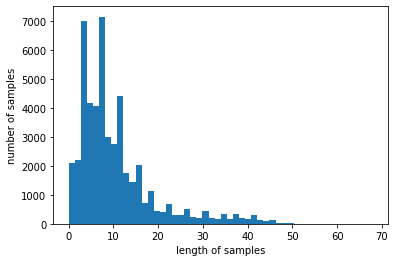

In [7]:
# check the distribution of sentence length
len_ser = train_data['document_processed'].str.len()
print('>>> max  sentence length :', len_ser.max())
print('>>> mean sentence length :', len_ser.mean())

len_ser.plot.hist(bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [8]:
# build & train Word2Vec model
model = Word2Vec(sentences=train_data['document_processed'], size=100, window=5, min_count=5, workers=4, sg=0)

print(model)
print(model.wv.vectors.shape)

Word2Vec(vocab=7065, size=100, alpha=0.025)
(7065, 100)


In [9]:
# check most similar words from given word
for tmp_word in ['최민식', '히어로', 'man']:
  try :
    tmp_list = model.wv.most_similar(tmp_word, topn=5)
    print(f'\n>>> {tmp_word} :')
    print(tmp_list)
  except Exception as e:
    print(f'\n>>> {e}')


>>> 최민식 :
[('홍금보', 0.9701711535453796), ('임청하', 0.9664468169212341), ('에드워드', 0.9620298147201538), ('최', 0.9612336754798889), ('디카프리오', 0.960641622543335)]

>>> 히어로 :
[('엑스맨', 0.9849721193313599), ('최고봉', 0.9835575222969055), ('로맨스코미디', 0.9806380271911621), ('건담', 0.9765819907188416), ('채플린', 0.9760320782661438)]

>>> "word 'man' not in vocabulary"
